### SARIMA:  
In sarima sessonal componennt is added to arima  
we can identity if seasonality is  there in series or not by  ploting and decomposition

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime  # for time formating
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

import statsmodels.api as sm


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/surendra769/Time-Series-Econometrics-and-Finance/main/AirPassengers.csv')
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df['Month'] = pd.to_datetime(df['Month'])


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


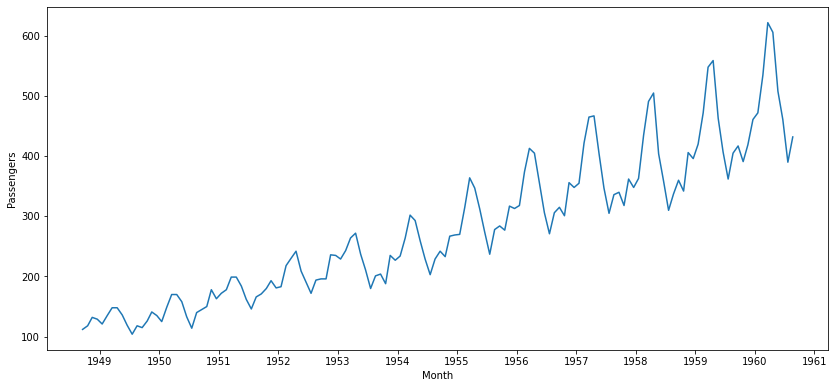

In [ ]:
plt.figure(figsize = (14,7))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     #specify the date foramt of  xaxis

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))  # specify  the interval, as we need yearly data label so we take  365 day  interval between  each label
plt.gcf().autofmt_xdate()    # manage the space

sns.lineplot(df['Month'], df['#Passengers'])
plt.ylabel('Passengers')

plt.xticks(rotation=0)     # rotate the xaxis value by 90 degree
plt.show();

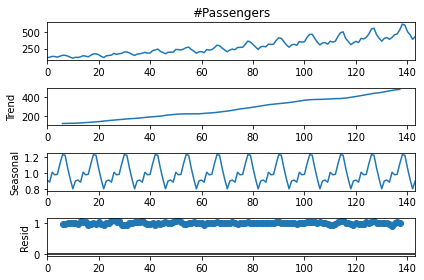

In [ ]:
## to get  the better idea about trend, cyclical variation and  residuall
decomposition = sm.tsa.seasonal_decompose(df['#Passengers'],period = 12, model = 'multiplicative' )
decomposition.plot()
plt.show()     # to get only one plot 

Inference: In both the graph we clery see the seassonal variation in yearly cycle where there is peak at mid year and low at end/start of year threfore we conclude that we will use SARIMA model for forecast.

In [9]:
## check the stationary  and also find that to make series stationary how much vlaue should of d and D

from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(df['#Passengers'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')  

# series is  not stationary

In [ ]:
# taken d = 1
df_diff = np.diff(df['#Passengers'], n=1)

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# still not stationary

ADF Statistic: -2.8292668241700056
p-value: 0.054213290283824704


In [ ]:
# now D = 1, difference jan with jan, june  with  june, as we have monthly data therefore we taken n = 12
df_diff_seasonal_diff = np.diff(df_diff, n=12)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# now it is stationary with d = 1, D = 1

ADF Statistic: -17.624862360208162
p-value: 3.823046855816801e-30


In [41]:
train.head()

0    112
1    118
2    132
3    129
4    121
Name: #Passengers, dtype: int64

In [38]:
train = df['#Passengers'][:-12]   # in train only take data
test = df.iloc[-12:]              # in test take date also


In [ ]:
from tqdm import tqdm_notebook
from typing import Union
from statsmodels.tsa.statespace.sarimax import SARIMAX


## develop the AIC for ARIMA model  to compare with SARIMA model

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
from tqdm import tqdm_notebook
from typing import Union
from statsmodels.tsa.statespace.sarimax import SARIMAX

## develop funcion to calculate AIC score  by taking consideration (p,d, q) and (P,D,Q)

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:   # s is m(frequnecy)
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
# for arima model
from itertools import product

ps = range(0, 13, 1)  # range for p,d,q
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12  # m frequency

ARIMA_order_list = list(product(ps, qs, Ps, Qs))


ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

<ipython-input-24-6d9de292a3c0>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/169 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


,"(p,q,P,Q)",AIC
0,"(11, 3, 0, 0)",1016.838574
1,"(11, 4, 0, 0)",1019.035143
2,"(11, 5, 0, 0)",1020.377155
3,"(11, 1, 0, 0)",1021.020676
4,"(12, 0, 0, 0)",1021.302125
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


best parmater are (p,d,q): (11,2,3)

In [31]:
## for SARIMA model parametert value range
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['#Passengers'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

<ipython-input-24-6d9de292a3c0>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stat

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.246510
1,"(2, 1, 2, 1)",893.977697
2,"(2, 1, 1, 3)",894.102076
3,"(1, 0, 1, 2)",894.288131
4,"(0, 1, 1, 2)",894.991254
...,...,...
250,"(0, 0, 2, 0)",906.940147
251,"(3, 2, 0, 3)",907.181875
252,"(0, 0, 3, 2)",907.467731
253,"(0, 0, 3, 0)",908.742583


best is (p,q,P,Q): (2,1,1,2)

In [32]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  132
Model:              SARIMAX(11, 2, 3)   Log Likelihood                -493.419
Date:                Sun, 25 Dec 2022   AIC                           1016.839
Time:                        06:31:02   BIC                           1059.852
Sample:                             0   HQIC                          1034.316
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8238      0.100     -8.216      0.000      -1.020      -0.627
ar.L2         -0.9631      0.049    -19.751      0.000      -1.059      -0.867
ar.L3         -0.8520      0.087     -9.748      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


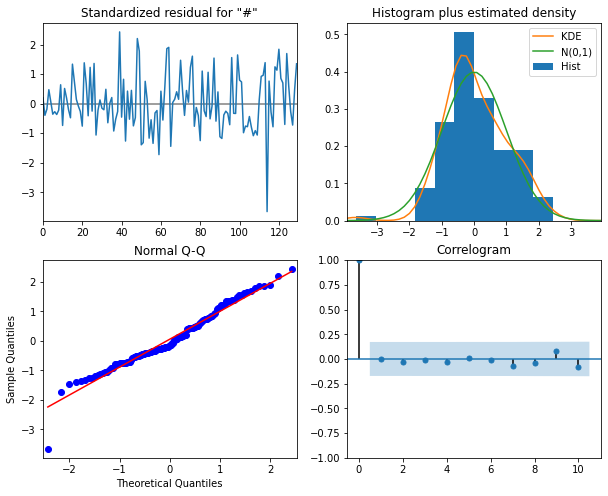

In [33]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));



In [34]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = ARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

[0.01042866 0.03530249 0.07286096 0.10078308 0.13538827 0.1920629
 0.2190932  0.28428485 0.37165742 0.31691372]


/usr/local/lib/python3.8/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


We see from plot that there is no correlation for any lag with in test we see for starting 2 lag p value is less than 0.05 value and there is correrlation.   
it show that sometime  plot dont show real picture so is best to use ljung test

In [42]:
## predict from ARIMA model

ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

<ipython-input-42-1879953193fa>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


,Month,#Passengers,ARIMA_pred
132,1960-01-01,417,422.371263
133,1960-02-01,391,410.636437
134,1960-03-01,419,461.826071
135,1960-04-01,461,457.830448
136,1960-05-01,472,481.700728
137,1960-06-01,535,531.112253
138,1960-07-01,622,606.151384
139,1960-08-01,606,615.481602
140,1960-09-01,508,525.628710
141,1960-10-01,461,467.122209


In [37]:
## develop SARIMA model
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)  # seasonal (P,D,Q,m)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                        SARIMAX Results                                        
Dep. Variable:                             #Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.123
Date:                                 Sun, 25 Dec 2022   AIC                            892.247
Time:                                         06:32:30   BIC                            911.700
Sample:                                              0   HQIC                           900.146
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2666      0.085    -14.966      0.000      -1.433      -1

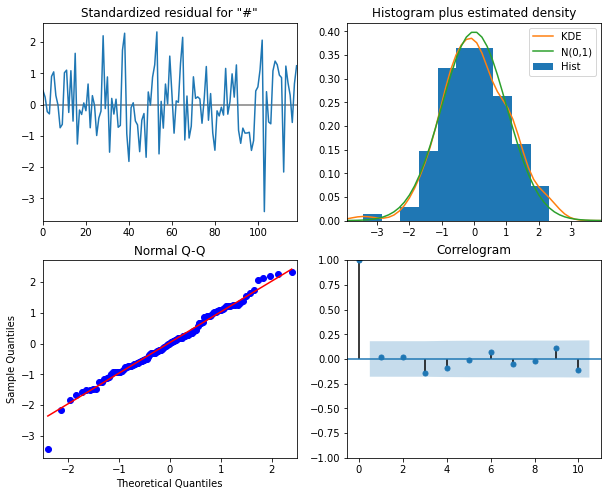

In [43]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));
## residual is normal

In [44]:
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)


# all are greater than 0.05 so they are uncorrlated

[0.9449489  0.68844235 0.79552469 0.87362863 0.92028172 0.94410987
 0.94073551 0.95078388 0.97390143 0.8933321 ]


/usr/local/lib/python3.8/dist-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [45]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

<ipython-input-45-20af5ea6c5b4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SARIMA_pred'] = SARIMA_pred


,Month,#Passengers,ARIMA_pred,SARIMA_pred
132,1960-01-01,417,422.371263,418.513809
133,1960-02-01,391,410.636437,399.579453
134,1960-03-01,419,461.826071,461.314936
135,1960-04-01,461,457.830448,451.443929
136,1960-05-01,472,481.700728,473.753350
137,1960-06-01,535,531.112253,538.792052
138,1960-07-01,622,606.151384,612.479835
139,1960-08-01,606,615.481602,624.663019
140,1960-09-01,508,525.628710,520.187434
141,1960-10-01,461,467.122209,462.856913


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


<Figure size 864x432 with 0 Axes>

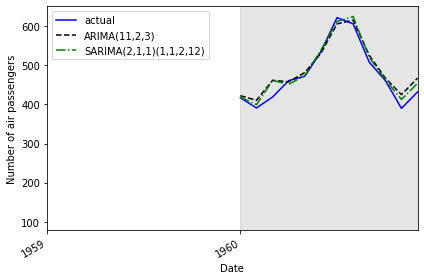

In [52]:
plt.figure(figsize = (12,6))
fig, ax = plt.subplots()

ax.plot(df['Month'], df['#Passengers'])
ax.plot(test['#Passengers'], 'b-', label='actual')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(11,2,3)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(2,1,1)(1,1,2,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()

In [53]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [55]:
mape_ARIMA = mape(test['#Passengers'], test['ARIMA_pred'])
mape_SARIMA = mape(test['#Passengers'], test['SARIMA_pred'])

print(mape_ARIMA, mape_SARIMA)

# SARIMA performm better

3.8409881024713646 2.8499980963917415


### SARIMAX   
In sarimax we also take consideration of exteral variable which can influence the Time Series  forecasting.  

There are two version: 1) ARIMAX 2) SARIMAX 

In [24]:
df = sm.datasets.macrodata.load_pandas().data
df.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


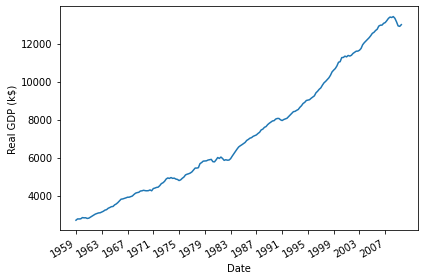

In [25]:
fig, ax = plt.subplots()

ax.plot(df['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

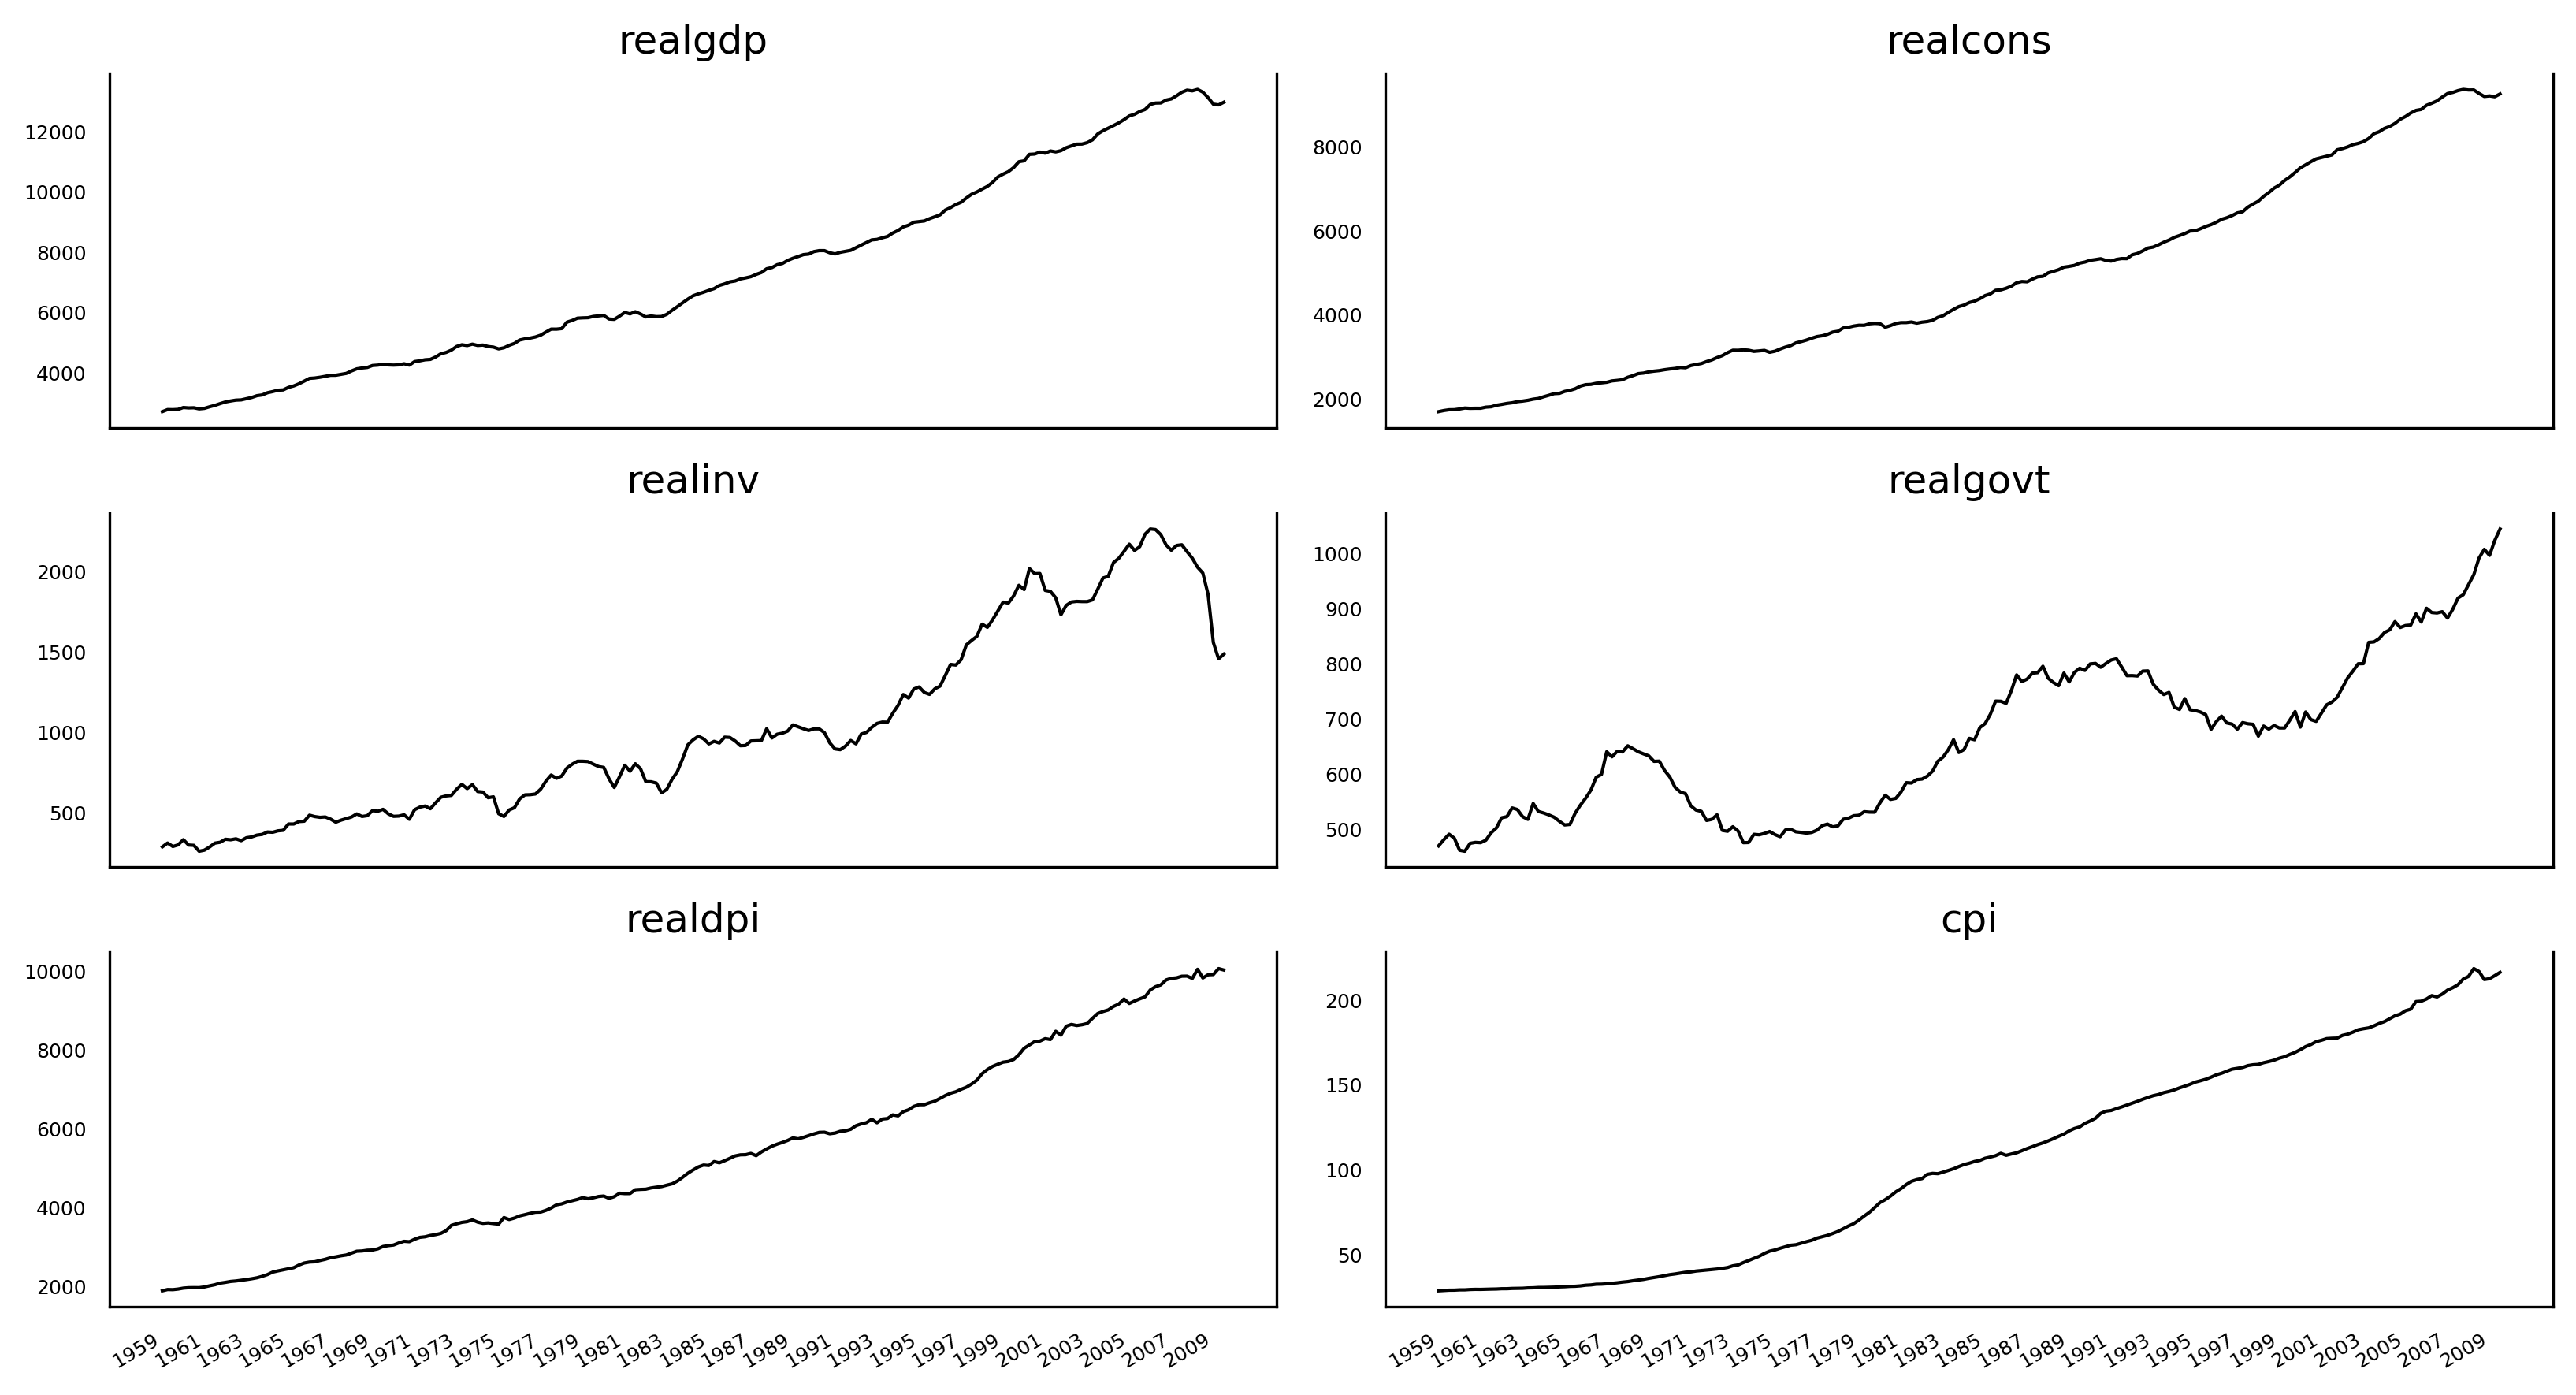

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))   # we will take 6 variable into consideration, real gdp is target variable

for i, ax in enumerate(axes.flatten()[:6]):
    data = df[df.columns[i+2]]
    
    ax.plot(data, color='black', linewidth=1)
    ax.set_title(df.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

In [27]:
target = df['realgdp']
exog = df[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [10]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# need to diff

ADF Statistic: 1.7504627967647162
p-value: 0.9982455372335032


In [28]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

#now it is stationary

ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08


In [29]:
from tqdm import tqdm_notebook
from itertools import product
from typing import Union


Exogenious: predictor variable  
Endogenous: Response variable

In [30]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


In [31]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)

P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4   # 4 value  in one cycle

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [32]:
exog

,realcons,realinv,realgovt,realdpi,cpi
0,1707.4,286.898,470.045,1886.9,28.980
1,1733.7,310.859,481.301,1919.7,29.150
2,1751.8,289.226,491.260,1916.4,29.350
3,1753.7,299.356,484.052,1931.3,29.370
4,1770.5,331.722,462.199,1955.5,29.540
...,...,...,...,...,...
198,9267.7,1990.693,991.551,9838.3,216.889
199,9195.3,1857.661,1007.273,9920.4,212.174
200,9209.2,1558.494,996.287,9926.4,212.671
201,9189.0,1456.678,1023.528,10077.5,214.469


In [33]:
target_train = target[:200]
exog_train = exog[:200]

In [37]:
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

<ipython-input-30-b2bd96ff433d>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/256 [00:00<?, ?it/s]

ValueError: ignored

In [38]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [40]:
target_train = target[:196]
target_test = target[196:]
from statsmodels.tsa.statespace.sarimax import SARIMAX

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimiz

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.062939
197,13415.266,13366.865,13373.511960
198,13324.600,13415.266,13378.811700
199,13141.920,13324.600,13327.758863
200,12925.410,13141.920,13133.230165
201,12901.504,12925.410,12887.707655
202,12990.341,12901.504,12873.795439


Complete